In [10]:
import torch
import torchdrug as td
from torchdrug import data,datasets
from torchdrug import core, models, tasks
%matplotlib inline

/home/jxy/anaconda3/envs/chemprop_1119/lib/python3.9/site-packages/torchdrug-0.1.2-py3.9.egg/torchdrug/data/graph.py:164: UserWarning: _maybe_num_node() is used to determine the number of nodes. This may underestimate the count if there are isolated nodes.
  warnings.warn("_maybe_num_node() is used to determine the number of nodes. "


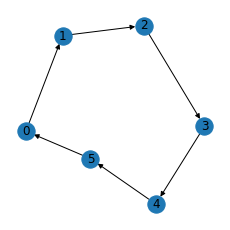

In [2]:
edge_list = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,0]]
graph = data.Graph(edge_list,num_nodes=6)
graph.visualize()

torch.Size([6, 69])
torch.Size([12, 19])


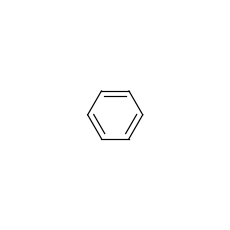

In [3]:
mol = data.Molecule.from_smiles("C1=CC=CC=C1")
mol.visualize()
print(mol.node_feature.shape)
print(mol.edge_feature.shape)

PackedMolecule(batch_size=4, num_nodes=[12, 6, 14, 9], num_edges=[22, 10, 30, 18], num_relation=4, device='cuda:0')


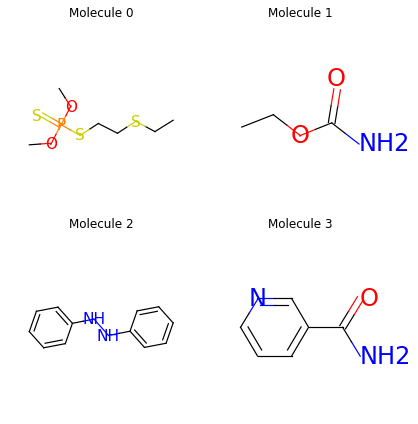

In [4]:
smiles_list = ["CCSCCSP(=S)(OC)OC", "CCOC(=O)N", "N(Nc1ccccc1)c2ccccc2", "NC(=O)c1cccnc1"]
mols = data.PackedMolecule.from_smiles(smiles_list)
mols.visualize()
mols = mols.cuda()
print(mols)

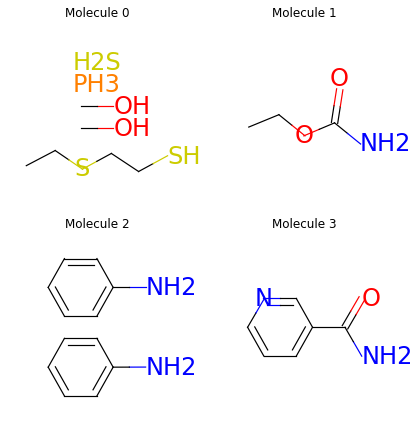

In [54]:
node_in,node_out,bond_type = mols.edge_list.t()
edge_mask = (mols.atom_type[node_in] == td.CARBON) | (mols.atom_type[node_out] == td.CARBON)
mols = mols.edge_mask(edge_mask)
mols.visualize()

In [11]:
dataset = datasets.ClinTox("~/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/home/jxy/anaconda3/envs/chemprop_1119/lib/python3.9/site-packages/torchdrug-0.1.2-py3.9.egg/torchdrug/data/feature.py:37: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
RDKit ERROR: [17:25:49] Explicit valence for atom # 0 N, 5, is greater than permitted
[17:25:49] Explicit valence for atom # 0 N, 5, is greater than permitted
/home/jxy/anaconda3/envs/chemprop_1119/lib/python3.9/site-packages/torchdrug-0.1.2-py3.9.egg/torchdrug/data/feature.py:37: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
/home/jxy/anaconda3/envs/chemprop_1119/lib/python3.9/site-packages/torchdrug-0.1.2-py3.9.egg/torchdrug/data/feature.py:37: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/home/jxy/anaconda3/envs/chemprop_1119/lib/python3.9/site-packages/torchdrug-0.1.2-py3.9.egg/torchdrug/data/feature.py:37: UserWarning: Unknown value `Al`
  warnings.warn("Unk

In [32]:
#sample = dataset[1].pop("graph")
sample = dataset[1]
sample.pop('graph')
#sample.visualize()
#node_in,node_out,bond_type = sample.pop("graph").edge_list.t()
#edge_mask = (sample.atom_type[node_in] == td.CARBON) | (sample.atom_type[node_out] == td.CARBON)
#graphs = sample.edge_mask(edge_mask)
#graphs.visualize()
label = ["%s: %d" % (k,v) for k,v in sample.items()]
#label[0][1].visualize()

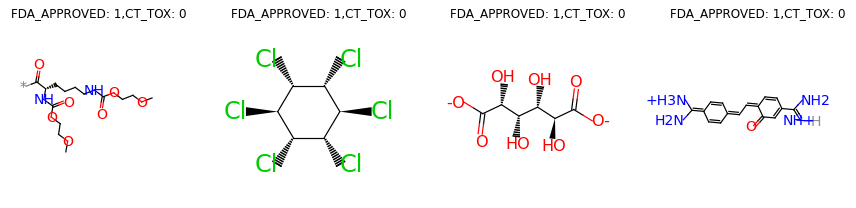

In [6]:
graphs = []
labels = []
for i in range(4):
    sample = dataset[i]
    graphs.append(sample.pop("graph"))
    label = ["%s: %d" % (k,v) for k,v in sample.items()]
    label = ",".join(label)
    labels.append(label)
graph = data.Molecule.pack(graphs)
graph.visualize(labels,num_row=1)

In [48]:
sample=dataset[2].pop('graph')
print(sample)
print(sample.node_feature.shape)
print(sample.edge_feature.shape)

Molecule(num_node=14, num_edge=26, num_relation=4)
torch.Size([14, 69])
torch.Size([26, 19])


In [12]:
model = models.GIN(input_dim=dataset.node_feature_dim,hidden_dims=[256,256,256,256],short_cut=True,batch_norm=True,concat_hidden=True)
task = tasks.PropertyPrediction(model,task=dataset.tasks,criterion="bce",metric=("auprc","auroc"))

In [13]:
optimizer = torch.optim.Adam(task.parameters(),lr=1e-3)
solver = core.Engine(task,train_set,valid_set,test_set,optimizer,batch_size=1024)
solver.train(num_epoch=100)
solver.evaluate("valid")

17:26:05   Preprocess training set
17:26:05   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
17:26:05   Epoch 0 begin


ImportError: /home/jxy/.cache/torch_extensions/py39_cu112/torch_ext_0/torch_ext.so: cannot open shared object file: No such file or directory